In [1]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Greek.txt', 'data/names/French.txt', 'data/names/English.txt', 'data/names/Korean.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Dutch.txt', 'data/names/Arabic.txt', 'data/names/Irish.txt', 'data/names/German.txt', 'data/names/Czech.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Spanish.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]

torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt: 





In [5]:
import torch.nn as nn
from torch.autograd import Variable

class MyLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLSTMLayer, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.forgetGate = nn.Linear(input_size + hidden_size, hidden_size)
        self.incorporatePositionGate = nn.Linear(input_size + hidden_size, hidden_size)
        self.incorporateValueGate = nn.Linear(input_size + hidden_size, hidden_size)
        self.hiddenValueGate = nn.Linear(hidden_size, hidden_size)
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward_step(self, input, hidden, cell_state):
        combined = torch.cat((input, hidden), 1)
        
        f = self.sigmoid(self.forgetGate(combined))
        i = self.sigmoid(self.incorporatePositionGate(combined))
        C_new = self.tanh(self.incorporateValueGate(combined))
        
        cell_state = f * cell_state + i * C_new
        
        hidden = self.relu(self.hiddenValueGate(cell_state))
        
        return hidden, cell_state
    
    def forward(self, input):
        hidden, cell_state = self.initAll()
        
        outputs = []
        
        for i in range(input.size()[0]):
            hidden, cell_state = self.forward_step(input[i], hidden, cell_state)
            outputs.append(hidden)
        
        return torch.stack(outputs)

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size)).cuda()
    
    def initCellState(self):
        return Variable(torch.zeros(1, self.hidden_size)).cuda()
    
    def initAll(self):
        return self.initHidden(), self.initCellState()

class myLSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, layers):
        super(myLSTM, self).__init__()
        
        self.lstm_layers = nn.ModuleList()
        input_sizes = [input_size] + hidden_sizes[:-1] 
        
        for input_size, hidden_size in zip(input_sizes, hidden_sizes):
            self.lstm_layers.append(MyLSTMLayer(input_size, hidden_size))
        
        self.outputGate = nn.Linear(hidden_sizes[-1], output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input):
        hiddens = input
        
        for i, lstm_layer in enumerate(self.lstm_layers):
            hiddens = lstm_layer(hiddens)
        
        return self.softmax(self.outputGate(hiddens[-1]))
        
n_hidden = 128
lstm = myLSTM(n_letters, [n_hidden, n_hidden], n_categories, 2).cuda()

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).

Remember that PyTorch modules operate on Variables rather than straight
up Tensors.




For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

We will also want a quick way to get a training example (a name and its
language):




In [7]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)])).cuda()
    line_tensor = Variable(lineToTensor(line)).cuda()
    return category, line, category_tensor, line_tensor

def pad(tensor, length):
    return torch.cat([tensor, tensor.new(length - tensor.size(0), *tensor.size()[1:]).zero_()])

# def randomBatch(batch_size):    
#     for _ in range(batch_size):
#         category, line, category_tensor, line_tensor = randomTrainingExample()
#         examples.append(line_tensor)
    
#     max_length = 0
    
#     for example in examples:
#         max_length = 

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Sayegh
category = Czech / line = Sokolik
category = Arabic / line = Sayegh
category = German / line = Walkenhorst
category = Portuguese / line = Romao
category = Spanish / line = Oquendo
category = Polish / line = Mozdzierz
category = Japanese / line = Ito
category = Korean / line = Kwak
category = Irish / line = Michael


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [8]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [9]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    lstm.zero_grad()

    output = lstm(line_tensor)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0]

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [10]:
import time
import math

n_iters = 300000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 1% (1m 20s) 2.9644 Cui / Japanese ✗ (Chinese)
10000 3% (2m 37s) 2.8699 Alo / Czech ✗ (Italian)
15000 5% (3m 53s) 2.9399 Paloumbas / French ✗ (Greek)
20000 6% (5m 11s) 2.4278 Rendon / Spanish ✓
25000 8% (6m 28s) 2.5251 Ibanez / Portuguese ✗ (Spanish)
30000 10% (7m 47s) 2.7673 Tsangaris / Czech ✗ (Greek)
35000 11% (9m 7s) 3.0767 Rusnak / Arabic ✗ (Polish)
40000 13% (10m 26s) 2.5525 Dubrovin / Japanese ✗ (Russian)
45000 15% (11m 42s) 2.7357 Kanavos / Czech ✗ (Greek)
50000 16% (13m 2s) 2.8633 Accorsi / Spanish ✗ (Italian)
55000 18% (14m 22s) 2.0152 Mateus / Portuguese ✓
60000 20% (15m 38s) 2.0321 Kalb / Arabic ✓
65000 21% (16m 56s) 1.9452 Shamon / Irish ✗ (Arabic)
70000 23% (18m 14s) 0.4907 Stamatelos / Greek ✓
75000 25% (19m 32s) 3.3283 Trumbauer / Irish ✗ (German)
80000 26% (20m 49s) 1.9699 Krivolavy / French ✗ (Czech)
85000 28% (22m 4s) 0.9974 Demetrious / Greek ✓
90000 30% (23m 21s) 0.4255 Thai / Vietnamese ✓
95000 31% (24m 42s) 2.1062 Macclelland / German ✗ (Irish)
100000 33% (25

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




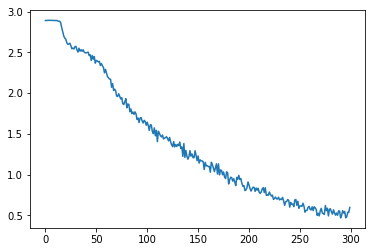

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




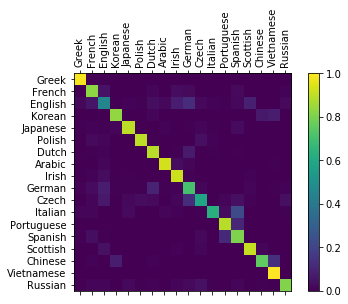

In [12]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = lstm(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [19]:
def predict(input_line, n_predictions=6):
    print('\n> %s' % input_line)
    output = lstm(Variable(lineToTensor(input_line)).cuda())

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Drissi')
predict('Ojha')
predict('Sandoval')
predict('Watkins')
predict('Segev')
predict('Sugiura')
predict('Draper')
predict('Mena')


> Drissi
(-0.04) Italian
(-4.30) Czech
(-4.41) Japanese
(-4.88) Arabic
(-5.67) Russian
(-6.29) Greek

> Ojha
(-0.32) Japanese
(-1.79) Russian
(-3.07) English
(-3.24) Irish
(-4.03) Czech
(-5.65) German

> Sandoval
(-0.70) Czech
(-1.06) Spanish
(-2.43) Russian
(-3.50) Italian
(-3.62) English
(-5.65) French

> Watkins
(-0.27) English
(-1.55) German
(-4.24) Russian
(-5.65) Czech
(-5.88) Scottish
(-5.89) Dutch

> Segev
(-0.05) Russian
(-3.74) German
(-4.52) Czech
(-4.81) English
(-6.61) Korean
(-7.66) Dutch

> Sugiura
(-0.01) Japanese
(-5.09) Russian
(-6.18) Greek
(-6.99) Irish
(-7.17) Italian
(-7.22) Arabic

> Draper
(-1.02) French
(-1.63) English
(-1.68) German
(-2.71) Czech
(-2.90) Dutch
(-2.92) Spanish

> Mena
(-0.45) Spanish
(-1.10) Portuguese
(-4.18) Italian
(-4.74) Czech
(-6.91) Dutch
(-7.05) French


In [14]:
number_of_samples = 1000
correct = 0

for i in range(1000):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = lstm(line_tensor)
    guess, _ = categoryFromOutput(output)
    correct += 1 if guess == category else 0

print(correct/10)

83.4


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


